In [72]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, MaxPooling1D, Conv2D, BatchNormalization, Dropout, SpatialDropout1D, Embedding, Conv1D, LSTM
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.utils import plot_model
import numpy as np 
import pandas as pd 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов

import os 
import time

!pip install kora -q
import kora.install.rdkit # по-дургому не запускалось
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_train = pd.read_csv('/content/train.csv')

In [ ]:
df_test

,Unnamed: 0,Smiles
0,0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...
...,...,...
1609,1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O
1610,1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1
1611,1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...
1612,1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1


In [ ]:
df_train

,Unnamed: 0,Smiles,Active
0,0,COc1ccc2[nH]cc(CCN)c2c1,False
1,1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False
...,...,...,...
5552,5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,False
5553,5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,False
5554,5554,Oc1cccc2cccnc12,False
5555,5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,False


In [ ]:
# оцениваю на пропуски
df_train.isna().sum()

Unnamed: 0    0
Smiles        0
Active        0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5557 non-null   int64 
 1   Smiles      5557 non-null   object
 2   Active      5557 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 92.4+ KB


In [ ]:
df_train.describe()

,Unnamed: 0
count,5557.000000
mean,2778.000000
std,1604.312054
min,0.000000
25%,1389.000000
50%,2778.000000
75%,4167.000000
max,5556.000000


#Автокодировщик

**Представляю Smiles в виде вектора**

In [17]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [18]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]
df_train_True.head()

,Smiles,Active
17,Nc1ccc(O)c2ncccc12,True
38,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,True
52,Cl.NCCc1cc(O)c(O)cc1O,True
111,Cc1ccc(-n2sc(=O)n(Cc3ccc(F)cc3)c2=O)cc1,True
122,Oc1cc2c(cc1C(c1ccc(C(F)(F)F)cc1)N1CCOCC1)OCO2,True


In [19]:
# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]
df_train_False.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [23]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [10]:
l = []
for i in s_inactive:
  l.append(len(i))
print(max(l), min(l))


598 6


In [11]:
# самая длинная молекула
for i in s_inactive:
  if len(i)== 598:
    print(i)

C=C(NC(=O)[C@@H](NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H]1CS[C@@H](C)[C@H]2NC(=O)C(=C)NC(=O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]3CS[C@@H](C)[C@@H](NC(=O)[C@H](CCCNN)NC(=O)[C@@H]4CS[C@@H](C)[C@@H](NC(=O)[C@@H]5CSC[C@@H](NC(=O)/C(=C\C)NC(=O)[C@@H](N)[C@@H](C)CC)C(=O)N[C@@H]([C@@H](C)CC)C(=O)NC(=C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N5)C(=O)N5CCC[C@H]5C(=O)NCC(=O)N4)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCSC)C(=O)NCC(=O)N3)[C@H](C)SC[C@H](NC2=O)C(=O)N[C@H](Cc2cnc[nH]2)C(=O)N1)[C@@H](C)CC)C(C)C)C(=O)N[C@@H](CCCCN)C(=O)O


In [12]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [13]:
l = []
for i in s_active:
  l.append(len(i))
print(max(l), min(l))

262 14


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=4096): # сделал nBits=4096
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример вектора smal_active: {smal_active[77]}')
print(f'Размер массива smal_active: {smal_active.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 4096
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_active: (206, 4096)


In [ ]:
# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример вектора smal_active: {smal_inactive[77]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

In [ ]:
# смотрю максимальные и минимальные значения
smal_inactive.max(), smal_inactive.min(), 

(1, 0)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(smal_inactive, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# размеры
X_train.shape, X_test.shape, smal_active.shape

((4280, 4096), (1071, 4096), (206, 4096))

In [ ]:
'''
# создаю Y_test для тестовой и Y_smal_active для активных молекул
Y_test = np.zeros(1071)
Y_smal_active = np.ones(206)

# размеры
Y_test.shape, Y_smal_active.shape
'''

((1071,), (206,))

In [ ]:
# Добавляю все активные молекулы в тестовый набор данных для того, чтобы потом сравнивать mse после обучения
X_test = np.concatenate((X_test, smal_active))
Y_test = np.concatenate((Y_test, Y_smal_active))

# размеры
X_test.shape, Y_test.shape

**Нейронная сеть**

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 2s 3ms/step - loss: 0.1992
Epoch 2/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0630
Epoch 3/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0261
Epoch 4/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0175
Epoch 5/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 6/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0127
Epoch 7/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 8/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0111
Epoch 9/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0107
Epoch 10/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0104
Epoch 11/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 12/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 13/100


**Проверка результата**

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
predictions.shape

(1277, 4096)

In [ ]:
predictions[9]

array([1.0093013e-04, 4.3236741e-05, 2.3633594e-02, ..., 2.5005715e-05,
       2.5241254e-05, 2.0602742e-05], dtype=float32)

In [ ]:
# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

In [ ]:
mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.001
Максимальная ошибка неактивных молекул: 0.0198
Средняя ошибка неактивных молекул: 0.0074242


In [ ]:
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка активных молекул: 0.0023
Максимальная ошибка активных молекул: 0.0203
Средняя ошибка активных молекул: 0.00701959


Я рассчитывал на то, что mse будет больше на активных молекулах, на которых сеть НЕ обучалась. Но по факту средняя ошибка на активных молекулах получилась практически одинаковая, чуть меньше. Активные => 0.0070, а неактивные => 0.0074

In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_Inactivel > bias # если ошибка больше порога - то неактивная
  isActive = mse_Active < bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.007)

Распознано неактивных молекул: 51%
Распознано активных молекул: 54%
Средняя точность распознавания: 53%


## Submit

In [ ]:
df_test = pd.read_csv('/content/test.csv', index_col = 0)
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [ ]:
# test
test_smiles = []
for i in df_test['Smiles']:
  test_smiles.append(i)

print('Длинна test_smiles:', len(test_smiles))
print("Пример значения из test_smiles:", test_smiles[1])

Длинна test_smiles: 1614
Пример значения из test_smiles: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12


In [ ]:
test = []
for i in test_smiles:
  sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
  test.append(sm)
test = np.array(test)             # преобразую в numpy
test.shape

(1614, 10000)

In [ ]:
predictions_test = model.predict(test) # делаем предсказание

In [ ]:
mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

Минимальная ошибка молекул: 0.0009
Максимальная ошибка молекул: 0.9688
Средняя ошибка молекул: 0.35042097


In [ ]:
mse_test.shape

In [ ]:
# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(mse_test)):
  if mse_test[i] >= 0.7:
    submission['Active'].values[i] = 1
  else:
    submission['Active'].values[i] = 0

In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
# соберу в функцию

def submission(df_test, bias):

  test_smiles = []
  for i in df_test['Smiles']:
    test_smiles.append(i)

  test = []
  for i in test_smiles:
    sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
    test.append(sm)
  test = np.array(test)             # преобразую в numpy
  
  predictions_test = model.predict(test) # делаем предсказание
  
  mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

  # Формирую табличку 
  submission = df_test
  submission['Active'] = ''
  
  for i in range(len(mse_test)):
    if mse_test[i] >= bias:
      submission['Active'].values[i] = 0
    else:
      submission['Active'].values[i] = 1
  
  submission.to_csv('submission.csv', index=False)

   
  print('Длинна test_smiles:', len(test_smiles))
  print("Пример значения из test_smiles:", test_smiles[1])
  print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
  print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
  print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

  return submission


##**Свертка Conv2D + Dense**

In [ ]:
X_train.shape, X_test.shape, smal_active.shape

((4280, 1024), (1277, 1024), (206, 1024))

In [ ]:
def Autoencoder_Conv2D(): 
    img_input = Input(shape=(1024,)) 

    x = Reshape((32,32,1))(img_input)

    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 4*4*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(4*4*256, activation='relu')(z) # и еще полносвязный слой
    x = Reshape((4,4,256))(x) # меняем размеры - картинка 4*4 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) 
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x) 
    x = Flatten()(x) # выпрямляю в вектор

    x = Dense(1024, activation='sigmoid')(x) # последний слой

    model = Model(img_input, x) 
    model.compile(optimizer='adam',
                  loss='mse') 

    return model 

In [ ]:
model_Conv2D = Autoencoder_Conv2D()
model_Conv2D.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 1024)              0   

In [ ]:
model_Conv2D = Autoencoder_Conv2D()

history = model_Conv2D.fit(X_train, X_train, epochs=10, batch_size=16) 

Epoch 1/10
268/268 [==============================] - 18s 22ms/step - loss: 0.2192
Epoch 2/10
268/268 [==============================] - 6s 21ms/step - loss: 0.1665
Epoch 3/10
268/268 [==============================] - 6s 21ms/step - loss: 0.1265
Epoch 4/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0969
Epoch 5/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0753
Epoch 6/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0594
Epoch 7/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0476
Epoch 8/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0387
Epoch 9/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0320
Epoch 10/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0267


**Проверка**

In [ ]:
predictions = model_Conv2D.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
predictions.shape

(1277, 1024)

In [ ]:
# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0227
Максимальная ошибка неактивных молекул: 0.0314
Средняя ошибка неактивных молекул: 0.02456381

Минимальная ошибка активных молекул: 0.0227
Максимальная ошибка активных молекул: 0.0284
Средняя ошибка активных молекул: 0.02491298


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_Inactivel < bias # если ошибка больше порога - то неактивная
  isActive = mse_Active > bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.0249)

Распознано неактивных молекул: 65%
Распознано активных молекул: 46%
Средняя точность распознавания: 56%


##**По-другому токенезирую, Bag Of Words**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# все молекулы
Smiles = s_active + s_inactive
len(Smiles)

5557

In [ ]:
maxWordsCount = 10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=False, split='', oov_token=None,   char_level=True)

tokenizer.fit_on_texts(Smiles) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:50]) # Посмотрим 10 самых часто встречающихся символов
print("Размер словаря", len(items)) # Длина словаря

[('c', 1), ('C', 2), ('(', 3), (')', 4), ('O', 5), ('1', 6), ('2', 7), ('=', 8), ('@', 9), ('N', 10), ('[', 11), (']', 12), ('H', 13), ('n', 14), ('3', 15), ('F', 16), ('4', 17), ('-', 18), ('l', 19), ('S', 20), ('/', 21), ('.', 22), ('5', 23), ('+', 24), ('s', 25), ('o', 26), ('#', 27), ('\\', 28), ('B', 29), ('r', 30), ('P', 31), ('I', 32), ('a', 33), ('6', 34), ('7', 35), ('A', 36), ('8', 37), ('i', 38), ('K', 39), ('Z', 40), ('g', 41), ('M', 42), ('L', 43), ('e', 44), ('9', 45)]
Размер словаря 45


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
s_inactive_WordIndexes = tokenizer.texts_to_sequences(s_inactive) # тесты в индексы
s_active_WordIndexes = tokenizer.texts_to_sequences(s_active) # тесты в индексы

print("Взглянем на Smiles:")
print("Как в таблице:              ", s_inactive[1])
print("В виде последовательности индексов: ", s_inactive_WordIndexes[1], '\n')
len(s_inactive[1]), len(s_inactive_WordIndexes[1])

Взглянем на Smiles:
Как в таблице:               CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
В виде последовательности индексов:  [2, 2, 2, 10, 6, 2, 2, 2, 11, 2, 9, 13, 12, 3, 1, 7, 1, 1, 1, 1, 3, 5, 4, 1, 7, 4, 2, 6, 22, 2, 19] 



(31, 31)

In [ ]:
len(s_inactive), len(s_inactive_WordIndexes)

(5351, 5351)

In [ ]:
X_tr = tokenizer.sequences_to_matrix(s_inactive_WordIndexes)
smal_active = tokenizer.sequences_to_matrix(s_active_WordIndexes)

print(X_tr.shape, smal_active.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(X_tr[0][0:100]) # Фрагмент в виде Bag of Words

(5351, 10000) (206, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
X_tr.max()

1.0

In [ ]:
RANDOM_SEED = 42

# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(X_tr, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
X_test = np.concatenate((X_test, smal_active))
X_test.shape

(1277, 10000)

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 100 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 100)               1100      
                                                                 
Total params: 2,110
Trainable params: 2,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 3s 2ms/step - loss: 0.2266
Epoch 2/100
357/357 [==============================] - 1s 2ms/step - loss: 0.1495
Epoch 3/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0821
Epoch 4/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0537
Epoch 5/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0438
Epoch 6/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0396
Epoch 7/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0373
Epoch 8/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0355
Epoch 9/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0338
Epoch 10/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0324
Epoch 11/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0311
Epoch 12/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0301
Epoch 13/100


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, X_train,
                    epochs=10,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 2/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 3/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 4/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 5/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 6/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Epoch 7/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 8/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 9/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0036
Epoch 10/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0035


In [ ]:
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 2/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0033
Epoch 3/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 4/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 5/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 6/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 7/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 8/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 9/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 10/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 11/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 12/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 13/100


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

history = model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 2/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 9/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 10/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 12/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 13/50
357/357 [====

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, X_train,
                    epochs=20,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 2/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 9/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 10/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 12/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 13/20
357/357 [====

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions.shape)

# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1277, 100)
(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0
Максимальная ошибка неактивных молекул: 0.0565
Средняя ошибка неактивных молекул: 0.00135621

Минимальная ошибка активных молекул: 0.0
Максимальная ошибка активных молекул: 0.0663
Средняя ошибка активных молекул: 0.00409747


In [ ]:
def getAccByBias(bias): 
  isInactive = mse_Inactivel < bias # тут поменял знаки, так как mse неактивных меньше
  isActive = mse_Active > bias # поменял знаки

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.0013)

Распознано неактивных молекул: 87%
Распознано активных молекул: 32%
Средняя точность распознавания: 59%


In [ ]:
# функцию submit

def submission(df_test, model, bias):

  test_smiles = []
  for i in df_test['Smiles']:
    test_smiles.append(i)

  test = []
  for i in test_smiles:
    sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
    test.append(sm)
  test = np.array(test)             # преобразую в numpy
  
  predictions_test = model.predict(test) # делаем предсказание
  
  mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

  # Формирую табличку 
  submission = df_test
  submission['Active'] = ''
  
  for i in range(len(mse_test)):
    if mse_test[i] >= bias:
      submission['Active'].values[i] = 0
    else:
      submission['Active'].values[i] = 1
  
  submission.to_csv('submission.csv', index=False)

   
  print('Длинна test_smiles:', len(test_smiles))
  print("Пример значения из test_smiles:", test_smiles[1])
  print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
  print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
  print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

  return submission

In [ ]:
df_test = pd.read_csv('/content/test.csv', index_col = 0)
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [ ]:
submission = submission(df_test, model, 0.00031)

Длинна test_smiles: 1614
Пример значения из test_smiles: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
Минимальная ошибка молекул: 0.0058
Максимальная ошибка молекул: 0.0805
Средняя ошибка молекул: 0.03111169


In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,0
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


#**Классификация на маленькой выборке**

**Всего по 206 примеров**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]
# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=10000):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример вектора smal_active: {smal_active[77]}')
print(f'Размер массива smal_active: {smal_active.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 10000
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_active: (206, 10000)


In [ ]:
# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример вектора smal_active: {smal_inactive[77]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 10000
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_inactive: (5351, 10000)


In [ ]:
smal_i = np.random.choice(5351, 206, replace = False)
smal_inactive = smal_inactive[smal_i]

Y_active = np.ones(206,)
print(Y_active.shape)

Y_inactive = np.zeros(206,)
print(Y_inactive.shape)

(206,)
(206,)


In [ ]:
X_tr = np.concatenate((smal_inactive, smal_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape

((412, 10000), (412,))

In [ ]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_tr, Y_tr, test_size=0.05, shuffle=True) #shuffle=True - перемешиваем
X_train_1.shape, X_test_1.shape, Y_train_1.shape, Y_test_1.shape

((391, 10000), (21, 10000), (391,), (21,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_1, Y_train_1, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((351, 10000), (40, 10000), (351,), (40,))

In [ ]:
def Model_cl(): 
  dataSize = 10000 # размер входного слоя
  dataInput = Input(shape=(dataSize)) 
  
  x = Dense(99, activation='relu')(dataInput) 
  x = BatchNormalization()(x)
  x = Dropout(0.7) (x)
  x = Dense(13, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dropout(0.1) (x)
  x = Dense(7, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dense(1, activation='sigmoid')(x) 
  
  model = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  
  return model

In [ ]:
model = Model_cl()
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 10000)]           0         
                                                                 
 dense_88 (Dense)            (None, 99)                990099    
                                                                 
 batch_normalization_66 (Bat  (None, 99)               396       
 chNormalization)                                                
                                                                 
 dropout_44 (Dropout)        (None, 99)                0         
                                                                 
 dense_89 (Dense)            (None, 13)                1300      
                                                                 
 batch_normalization_67 (Bat  (None, 13)               52        
 chNormalization)                                         

Epoch 1/60
22/22 [==============================] - 3s 28ms/step - loss: 0.8234 - accuracy: 0.5071 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 2/60
22/22 [==============================] - 0s 9ms/step - loss: 0.7604 - accuracy: 0.5356 - val_loss: 0.6903 - val_accuracy: 0.4750
Epoch 3/60
22/22 [==============================] - 0s 9ms/step - loss: 0.7541 - accuracy: 0.5271 - val_loss: 0.6934 - val_accuracy: 0.4750
Epoch 4/60
22/22 [==============================] - 0s 9ms/step - loss: 0.7379 - accuracy: 0.5356 - val_loss: 0.6946 - val_accuracy: 0.4750
Epoch 5/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6878 - accuracy: 0.5527 - val_loss: 0.6975 - val_accuracy: 0.4750
Epoch 6/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6872 - accuracy: 0.6040 - val_loss: 0.6980 - val_accuracy: 0.4750
Epoch 7/60
22/22 [==============================] - 0s 9ms/step - loss: 0.6689 - accuracy: 0.5954 - val_loss: 0.6989 - val_accuracy: 0.4750
Epoch 8/60
22/22 [=

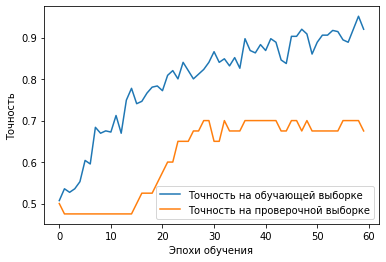

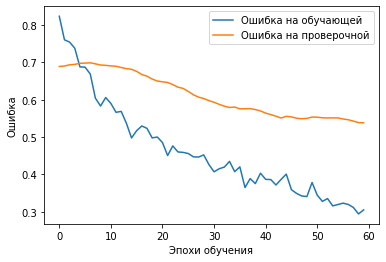

In [ ]:
model = Model_cl()

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=16,    # Размер батча
          epochs=60,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/100
22/22 [==============================] - 2s 19ms/step - loss: 0.3282 - accuracy: 0.8832 - val_loss: 0.5363 - val_accuracy: 0.7000
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 0.3031 - accuracy: 0.9174 - val_loss: 0.5332 - val_accuracy: 0.7000
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.3156 - accuracy: 0.9088 - val_loss: 0.5328 - val_accuracy: 0.7000
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 0.3022 - accuracy: 0.9202 - val_loss: 0.5331 - val_accuracy: 0.7000
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 0.3263 - accuracy: 0.9003 - val_loss: 0.5310 - val_accuracy: 0.7000
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.3185 - accuracy: 0.9202 - val_loss: 0.5334 - val_accuracy: 0.7000
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 0.3100 - accuracy: 0.9088 - val_loss: 0.5328 - val_accuracy: 0.7000
Epoch 8/100

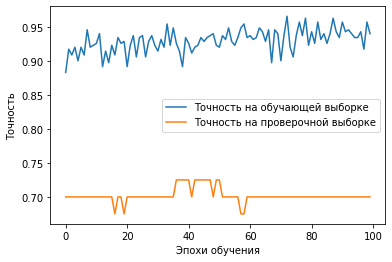

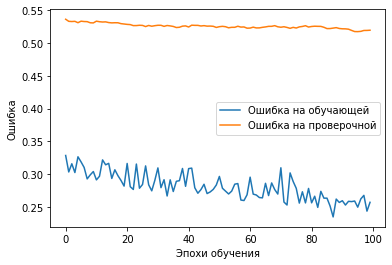

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=16,    # Размер батча
          epochs=100,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(X_test_1, Y_test_1, verbose=1)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

1/1 [==============================] - 0s 36ms/step - loss: 0.7218 - accuracy: 0.5714
[0.7218173742294312, 0.5714285969734192]
Доля верных ответов на тестовых данных, в процентах: 57.1429%


In [ ]:
pred = model.predict(X_test_1)

In [ ]:
mse = np.mean(np.power(Y_test_1 - pred, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse_IN = mse[Y_test_1 == 0] 
mse_AC = mse[Y_test_1 == 1] 

In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_IN),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_IN),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_IN) / len(mse_IN),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.2041
Максимальная ошибка неактивных молекул: 0.6869
Средняя ошибка неактивных молекул: 0.34205021


In [ ]:
print("Минимальная ошибка активных молекул:", round(min(mse_AC),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_AC),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_AC) / len(mse_AC),8)) # средняя ошибка

Минимальная ошибка активных молекул: 0.2059
Максимальная ошибка активных молекул: 0.5673
Средняя ошибка активных молекул: 0.36964711


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_IN < bias # если ошибка больше порога - то неактивная
  isActive = mse_AC > bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.35)

Распознано неактивных молекул: 73%
Распознано активных молекул: 50%
Средняя точность распознавания: 62%


**Пока это самый лучший результат из нейросетей.**

##Данные в Bag Of Words

In [ ]:
maxWordsCount = 10000 

# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=False, split='', oov_token=None,   char_level=True)

tokenizer.fit_on_texts(Smiles) 
items = list(tokenizer.word_index.items()) 

In [ ]:
print(items[:50]) # Посмотрим 50 самых часто встречающихся символов
print("Размер словаря", len(items)) # Длина словаря

[('c', 1), ('C', 2), ('(', 3), (')', 4), ('O', 5), ('1', 6), ('2', 7), ('=', 8), ('@', 9), ('N', 10), ('[', 11), (']', 12), ('H', 13), ('n', 14), ('3', 15), ('F', 16), ('4', 17), ('-', 18), ('l', 19), ('S', 20), ('/', 21), ('.', 22), ('5', 23), ('+', 24), ('s', 25), ('o', 26), ('#', 27), ('\\', 28), ('B', 29), ('r', 30), ('P', 31), ('I', 32), ('a', 33), ('6', 34), ('7', 35), ('A', 36), ('8', 37), ('i', 38), ('K', 39), ('Z', 40), ('g', 41), ('M', 42), ('L', 43), ('e', 44), ('9', 45)]
Размер словаря 45


In [ ]:
smal_inactive = tokenizer.sequences_to_matrix(s_inactive_WordIndexes)
smal_active = tokenizer.sequences_to_matrix(s_active_WordIndexes)

print(X_tr.shape, smal_active.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(X_tr[0][0:100]) # Фрагмент в виде Bag of Words

(412, 10000) (206, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
smal_i = np.random.choice(5351, 206, replace = False)
smal_inactive = smal_inactive[smal_i]

Y_active = np.ones(206,)
print(Y_active.shape)
print(Y_active[8])

Y_inactive = np.zeros(206,)
print(Y_inactive.shape)
print(Y_inactive[8])

(206,)
1.0
(206,)
0.0


In [ ]:
X_tr = np.concatenate((smal_inactive, smal_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape

((412, 10000), (412,))

In [ ]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_tr, Y_tr, test_size=0.05, shuffle=True) #shuffle=True - перемешиваем
X_train_1.shape, X_test_1.shape, Y_train_1.shape, Y_test_1.shape

((391, 10000), (21, 10000), (391,), (21,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_1, Y_train_1, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((351, 10000), (40, 10000), (351,), (40,))

In [ ]:
def Model_cl(): 
  dataSize = 10000 # размер входного слоя
  dataInput = Input(shape=(dataSize)) 
  
  x = Dense(3000, activation='relu')(dataInput) 
  #x = BatchNormalization()(x)
  x = Dropout(0.7) (x)
  x = BatchNormalization()(x)
  #x = Dense(3, activation='relu') (x)
  #x = BatchNormalization()(x)
  #x = Dropout(0.5) (x)
  x = Dense(2, activation='relu') (x)
  #x = BatchNormalization()(x)
  #x = Dropout(0.1) (x)
  x = Dense(1, activation='sigmoid')(x) 
  
  model = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
  
  return model

In [ ]:
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 10000)]           0         
                                                                 
 dense_92 (Dense)            (None, 99)                990099    
                                                                 
 batch_normalization_69 (Bat  (None, 99)               396       
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 99)                0         
                                                                 
 dense_93 (Dense)            (None, 13)                1300      
                                                                 
 batch_normalization_70 (Bat  (None, 13)               52        
 chNormalization)                                         

Epoch 1/30
22/22 [==============================] - 2s 36ms/step - loss: 0.7656 - accuracy: 0.4986 - val_loss: 0.6936 - val_accuracy: 0.5500
Epoch 2/30
22/22 [==============================] - 0s 20ms/step - loss: 0.7211 - accuracy: 0.5185 - val_loss: 0.6936 - val_accuracy: 0.5250
Epoch 3/30
22/22 [==============================] - 0s 19ms/step - loss: 0.7367 - accuracy: 0.4986 - val_loss: 0.6935 - val_accuracy: 0.4750
Epoch 4/30
22/22 [==============================] - 0s 19ms/step - loss: 0.7347 - accuracy: 0.5271 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/30
22/22 [==============================] - 1s 33ms/step - loss: 0.7048 - accuracy: 0.5100 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/30
22/22 [==============================] - 0s 18ms/step - loss: 0.7119 - accuracy: 0.5242 - val_loss: 0.6931 - val_accuracy: 0.5500
Epoch 7/30
22/22 [==============================] - 0s 16ms/step - loss: 0.7220 - accuracy: 0.5385 - val_loss: 0.6930 - val_accuracy: 0.5500
Epoch 8/30
22

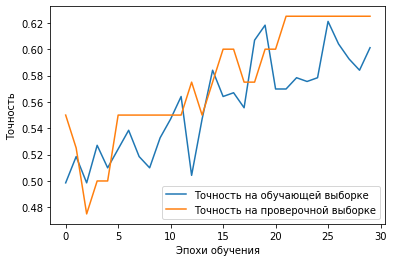

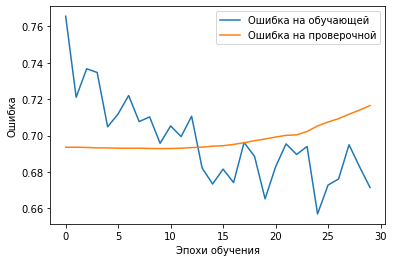

In [ ]:
model = Model_cl()

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=16,    # Размер батча
          epochs=30,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/50
30/30 [==============================] - 53s 24ms/step - loss: 0.6621 - accuracy: 0.6296 - val_loss: 0.6467 - val_accuracy: 0.6500
Epoch 2/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6629 - accuracy: 0.6154 - val_loss: 0.6462 - val_accuracy: 0.6500
Epoch 3/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6640 - accuracy: 0.6382 - val_loss: 0.6462 - val_accuracy: 0.6250
Epoch 4/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6645 - accuracy: 0.6268 - val_loss: 0.6459 - val_accuracy: 0.6250
Epoch 5/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6536 - accuracy: 0.6296 - val_loss: 0.6455 - val_accuracy: 0.6500
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6690 - accuracy: 0.6211 - val_loss: 0.6459 - val_accuracy: 0.6250
Epoch 7/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6698 - accuracy: 0.6154 - val_loss: 0.6460 - val_accuracy: 0.6250
Epoch 8/50
3

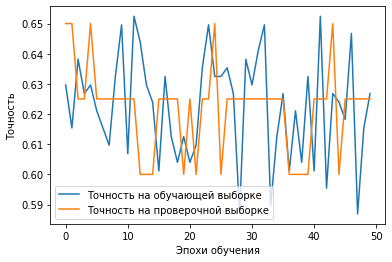

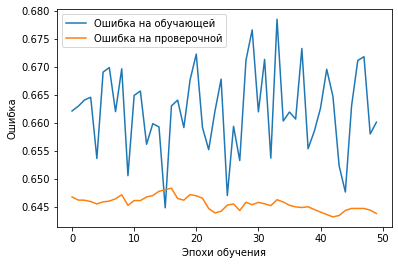

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])
# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=12,    # Размер батча
          epochs=50,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

##**2 нейрона, softmax и loss='categorical_crossentropy'**

In [ ]:
smal_active = s_ac

In [ ]:
smal_i = np.random.choice(5351, 206, replace = False)
smal_inactive = s_in[smal_i]

Y_active = np.ones(206,)
print(Y_active.shape)

Y_inactive = np.zeros(206,)
print(Y_inactive.shape)

(206,)
(206,)


In [ ]:
X_tr = np.concatenate((smal_inactive, smal_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape

((412, 167), (412,))

In [ ]:
# преобразую в hot
Y_tr = utils.to_categorical(Y_tr, 2)
print(Y_tr.shape)
print(Y_tr[5])
print(Y_tr[300])

(412, 2)
[1. 0.]
[0. 1.]


In [ ]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_tr, Y_tr, test_size=0.05, shuffle=True) #shuffle=True - перемешиваем
X_train_1.shape, X_test_1.shape, Y_train_1.shape, Y_test_1.shape

((391, 167), (21, 167), (391, 2), (21, 2))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_1, Y_train_1, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((351, 167), (40, 167), (351, 2), (40, 2))

In [ ]:
def Model_cl(): 
  dataSize = 167 # размер входного слоя
  dataInput = Input(shape=(dataSize)) 
  
  x = Dense(99, activation='relu')(dataInput) 
  x = BatchNormalization()(x)
  x = Dropout(0.7) (x)
  x = Dense(13, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dropout(0.1) (x)
  x = Dense(7, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dense(2, activation='softmax')(x) 
  
  model = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  
  return model

In [ ]:
model = Model_cl()
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 167)]             0         
                                                                 
 dense_52 (Dense)            (None, 99)                16632     
                                                                 
 batch_normalization_39 (Bat  (None, 99)               396       
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 99)                0         
                                                                 
 dense_53 (Dense)            (None, 13)                1300      
                                                                 
 batch_normalization_40 (Bat  (None, 13)               52        
 chNormalization)                                         

Epoch 1/60
22/22 [==============================] - 2s 18ms/step - loss: 0.8973 - accuracy: 0.5214 - val_loss: 0.7227 - val_accuracy: 0.4750
Epoch 2/60
22/22 [==============================] - 0s 9ms/step - loss: 0.9307 - accuracy: 0.5157 - val_loss: 0.6956 - val_accuracy: 0.5250
Epoch 3/60
22/22 [==============================] - 0s 8ms/step - loss: 0.8860 - accuracy: 0.5328 - val_loss: 0.6855 - val_accuracy: 0.5500
Epoch 4/60
22/22 [==============================] - 0s 9ms/step - loss: 0.8636 - accuracy: 0.5157 - val_loss: 0.6827 - val_accuracy: 0.5750
Epoch 5/60
22/22 [==============================] - 0s 9ms/step - loss: 0.8969 - accuracy: 0.4900 - val_loss: 0.6802 - val_accuracy: 0.5750
Epoch 6/60
22/22 [==============================] - 0s 8ms/step - loss: 0.8141 - accuracy: 0.5527 - val_loss: 0.6773 - val_accuracy: 0.6000
Epoch 7/60
22/22 [==============================] - 0s 10ms/step - loss: 0.8688 - accuracy: 0.5356 - val_loss: 0.6721 - val_accuracy: 0.6250
Epoch 8/60
22/22 [

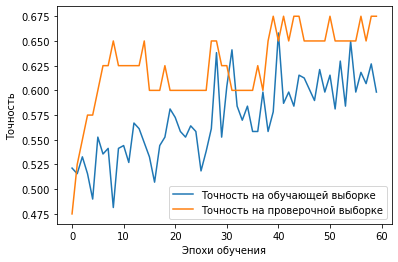

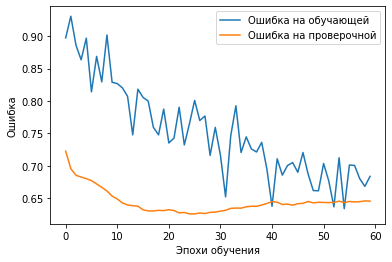

In [ ]:
model = Model_cl()

# Обучаем сеть
history = model.fit(X_train,
          Y_train,         
          batch_size=16,    
          epochs=60,        
          validation_data=(X_test, Y_test))        

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/60
22/22 [==============================] - 2s 20ms/step - loss: 0.6904 - accuracy: 0.5954 - val_loss: 0.6461 - val_accuracy: 0.6750
Epoch 2/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6564 - accuracy: 0.6382 - val_loss: 0.6461 - val_accuracy: 0.6500
Epoch 3/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6513 - accuracy: 0.6353 - val_loss: 0.6476 - val_accuracy: 0.6500
Epoch 4/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6744 - accuracy: 0.6268 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 5/60
22/22 [==============================] - 0s 10ms/step - loss: 0.6844 - accuracy: 0.6068 - val_loss: 0.6470 - val_accuracy: 0.6500
Epoch 6/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6429 - accuracy: 0.6353 - val_loss: 0.6468 - val_accuracy: 0.6750
Epoch 7/60
22/22 [==============================] - 0s 8ms/step - loss: 0.6485 - accuracy: 0.6182 - val_loss: 0.6476 - val_accuracy: 0.6750
Epoch 8/60
22/22 [

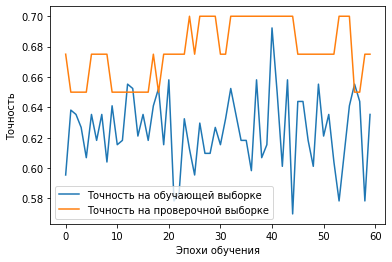

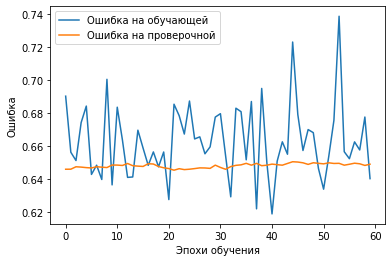

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
# Обучаем сеть
history = model.fit(X_train,
          Y_train,         
          batch_size=16,    
          epochs=60,        
          validation_data=(X_test, Y_test))        

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
n = 37
prediction = model.predict(X_test)

print("Выход сети: ", prediction[n])
print("Распознанная молекула: ", np.argmax(prediction[n]))
print("Верный ответ: ", np.argmax(Y_test[n]))

Выход сети:  [0.80151814 0.19848181]
Распознанная молекула:  0
Верный ответ:  0


In [ ]:
prediction.shape

(40, 2)

In [ ]:
b = 0
for i in range(len(prediction)):
  p = np.argmax(prediction[i])
  y = np.argmax(Y_test[i])
  if y == p:
    b += 1
print("Средняя точность распознавания: ", round(b / len(prediction),4), "%", sep="") 

Средняя точность распознавания: 0.675%


In [ ]:
predictions_test = model.predict(test) # делаем предсказание
predictions_test.shape

(1614, 2)

In [ ]:
# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(predictions_test)):
  submission['Active'].values[i] = np.argmax(predictions_test[i])

submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


#**Embedding**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
l = []
for i in s_inactive:
  l.append(len(i))
print(max(l), min(l))


598 6


In [ ]:
# самая длинная молекула
for i in s_inactive:
  if len(i) == 598:
    print(i)

C=C(NC(=O)[C@@H](NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H]1CS[C@@H](C)[C@H]2NC(=O)C(=C)NC(=O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]3CS[C@@H](C)[C@@H](NC(=O)[C@H](CCCNN)NC(=O)[C@@H]4CS[C@@H](C)[C@@H](NC(=O)[C@@H]5CSC[C@@H](NC(=O)/C(=C\C)NC(=O)[C@@H](N)[C@@H](C)CC)C(=O)N[C@@H]([C@@H](C)CC)C(=O)NC(=C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N5)C(=O)N5CCC[C@H]5C(=O)NCC(=O)N4)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCSC)C(=O)NCC(=O)N3)[C@H](C)SC[C@H](NC2=O)C(=O)N[C@H](Cc2cnc[nH]2)C(=O)N1)[C@@H](C)CC)C(C)C)C(=O)N[C@@H](CCCCN)C(=O)O


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# все молекулы
Smiles = s_active + s_inactive
len(Smiles)

5557

In [ ]:
maxWordsCount = 1024 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=False, split='', oov_token=None, char_level=True)

tokenizer.fit_on_texts(Smiles) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:50]) # Посмотрим 10 самых часто встречающихся символов
print("Размер словаря", len(items)) # Длина словаря

[('c', 1), ('C', 2), ('(', 3), (')', 4), ('O', 5), ('1', 6), ('2', 7), ('=', 8), ('@', 9), ('N', 10), ('[', 11), (']', 12), ('H', 13), ('n', 14), ('3', 15), ('F', 16), ('4', 17), ('-', 18), ('l', 19), ('S', 20), ('/', 21), ('.', 22), ('5', 23), ('+', 24), ('s', 25), ('o', 26), ('#', 27), ('\\', 28), ('B', 29), ('r', 30), ('P', 31), ('I', 32), ('a', 33), ('6', 34), ('7', 35), ('A', 36), ('8', 37), ('i', 38), ('K', 39), ('Z', 40), ('g', 41), ('M', 42), ('L', 43), ('e', 44), ('9', 45)]
Размер словаря 45


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
s_inactive_WordIndexes = tokenizer.texts_to_sequences(s_inactive) # тесты в индексы
s_active_WordIndexes = tokenizer.texts_to_sequences(s_active) # тесты в индексы

print("Взглянем на Smiles:")
print("Как в таблице:              ", s_inactive[1])
print("В виде последовательности индексов: ", s_inactive_WordIndexes[1], '\n')
len(s_inactive[1]), len(s_inactive_WordIndexes[1])

Взглянем на Smiles:
Как в таблице:               CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
В виде последовательности индексов:  [2, 2, 2, 10, 6, 2, 2, 2, 11, 2, 9, 13, 12, 3, 1, 7, 1, 1, 1, 1, 3, 5, 4, 1, 7, 4, 2, 6, 22, 2, 19] 



(31, 31)

In [ ]:
len(s_inactive[9]), len(s_inactive_WordIndexes[9])

(35, 35)

In [ ]:
# самая длинная молекула
for i in s_inactive_WordIndexes:
  if len(i) == 598:
    print(i)

[2, 8, 2, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 1, 6, 1, 14, 1, 11, 14, 13, 12, 6, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 5, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 6, 2, 20, 11, 2, 9, 9, 13, 12, 3, 2, 4, 11, 2, 9, 13, 12, 7, 10, 2, 3, 8, 5, 4, 2, 3, 8, 2, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 2, 2, 10, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 20, 2, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 3, 10, 4, 8, 5, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 15, 2, 20, 11, 2, 9, 9, 13, 12, 3, 2, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 2, 10, 10, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 17, 2, 20, 11, 2, 9, 9, 13, 12, 3, 2, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 23, 2, 20, 2, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 21, 2, 3, 8, 2, 28, 2, 4, 10, 2, 3, 8, 5, 4, 11, 

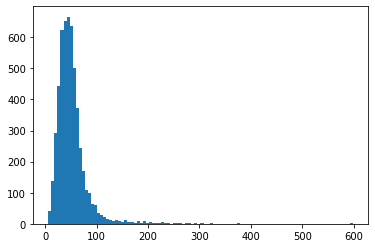

In [ ]:
lenXTrainE = [len(x) for x in s_inactive]
plt.hist(lenXTrainE, 100)
plt.show()

In [ ]:
# добиваю нулями токенизированные молекулы
maxlen = 600

xInactivE = pad_sequences(s_inactive_WordIndexes, maxlen=maxlen) 
xActivE = pad_sequences(s_active_WordIndexes, maxlen=maxlen) 

In [ ]:
# максимальный и минимальный токены в молекулах
print(xInactivE.max(), xInactivE.min())
print(xActivE.max(), xActivE.min())

45 0
44 0


In [ ]:
print(xInactivE.shape, xActivE.shape)

(5351, 600) (206, 600)


In [ ]:
s_inactive = np.random.choice(5351, 206, replace = False)

X_inactive_Em = xInactivE[s_inactive]
print(X_inactive_Em.shape)
print(X_inactive_Em[55])

(206, 600)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
X_active_Em = xActivE
print(X_active_Em.shape)
print(X_active_Em[55])


(206, 600)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
Y_inactive_Em = np.zeros(206)
print(Y_inactive_Em.shape)
print(Y_inactive_Em[9])

(206,)
0.0


In [ ]:
Y_active_Em = np.ones(206,)
print(Y_active_Em.shape)
print(Y_active_Em[9])

(206,)
1.0


In [ ]:
X_Em = np.concatenate((X_inactive_Em, X_active_Em))
Y_Em = np.concatenate((Y_inactive_Em, Y_active_Em))
print(X_Em.shape)
print(Y_Em.shape)


(412, 600)
(412,)


In [ ]:
X_tr, X_test, Y_tr, Y_test = train_test_split(X_Em, Y_Em, test_size=0.05, shuffle=True)
X_tr.shape, Y_tr.shape, X_test.shape, Y_test.shape

((391, 600), (391,), (21, 600), (21,))

In [ ]:
X_train, X_test_2, Y_train, Y_test_2 = train_test_split(X_tr, Y_tr, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, Y_train.shape, X_test_2.shape, Y_test_2.shape

((351, 600), (351,), (40, 600), (40,))

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 600 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) 
  
  x = Embedding(maxWordsCount, 20, input_length=maxlen) (dataInput)
  x = Dense(10, activation='relu')(x) 
  #x = Dense(20, activation='sigmoid')(x) #
  x = Flatten() (x)
  x = Dense(1, activation='sigmoid')(x)

  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) 
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 600, 20)           20480     
                                                                 
 dense_4 (Dense)             (None, 600, 10)           210       
                                                                 
 flatten_2 (Flatten)         (None, 6000)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 6001      
                                                                 
Total params: 26,691
Trainable params: 26,691
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, Y_train,
                    epochs=150,
                    batch_size=12,
                    validation_data= (X_test_2, Y_test_2),
                    verbose=1)    

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()    

Epoch 1/150
30/30 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6937 - val_accuracy: 0.4750
Epoch 2/150
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5413 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/150
30/30 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5755 - val_loss: 0.6935 - val_accuracy: 0.5250
Epoch 4/150
30/30 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5527 - val_loss: 0.6935 - val_accuracy: 0.4750
Epoch 5/150
30/30 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.5527 - val_loss: 0.6934 - val_accuracy: 0.4750
Epoch 6/150
30/30 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5470 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/150
30/30 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5527 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/150


Epoch 1/100
30/30 [==============================] - 2s 27ms/step - loss: 0.4235 - accuracy: 0.8376 - val_loss: 0.5079 - val_accuracy: 0.7143
Epoch 2/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4231 - accuracy: 0.8433 - val_loss: 0.5060 - val_accuracy: 0.7143
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4228 - accuracy: 0.8376 - val_loss: 0.5032 - val_accuracy: 0.7143
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.4227 - accuracy: 0.8405 - val_loss: 0.5037 - val_accuracy: 0.7143
Epoch 5/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4224 - accuracy: 0.8433 - val_loss: 0.5017 - val_accuracy: 0.7143
Epoch 6/100
30/30 [==============================] - 0s 16ms/step - loss: 0.4221 - accuracy: 0.8405 - val_loss: 0.4996 - val_accuracy: 0.7619
Epoch 7/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4220 - accuracy: 0.8405 - val_loss: 0.4967 - val_accuracy: 0.8095
Epoch 

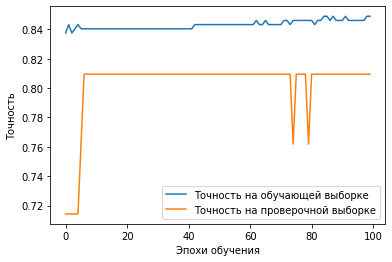

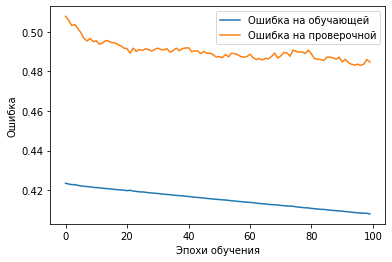

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train, Y_train,
                    epochs=100,
                    batch_size=12,
                    validation_data= (X_test_2, Y_test_2),
                    verbose=1)    

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()  

Epoch 1/100
30/30 [==============================] - 2s 25ms/step - loss: 0.4078 - accuracy: 0.8490 - val_loss: 0.4850 - val_accuracy: 0.8095
Epoch 2/100
30/30 [==============================] - 0s 14ms/step - loss: 0.4077 - accuracy: 0.8490 - val_loss: 0.4848 - val_accuracy: 0.8095
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 0.4077 - accuracy: 0.8490 - val_loss: 0.4847 - val_accuracy: 0.8095
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.4077 - accuracy: 0.8490 - val_loss: 0.4848 - val_accuracy: 0.8095
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4077 - accuracy: 0.8490 - val_loss: 0.4847 - val_accuracy: 0.8095
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4077 - accuracy: 0.8490 - val_loss: 0.4847 - val_accuracy: 0.8095
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4077 - accuracy: 0.8490 - val_loss: 0.4846 - val_accuracy: 0.8095
Epoch 8/1

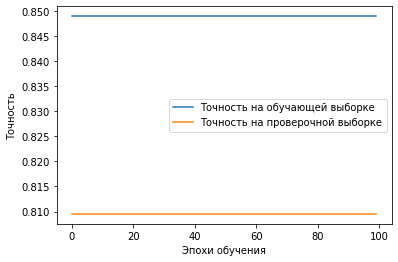

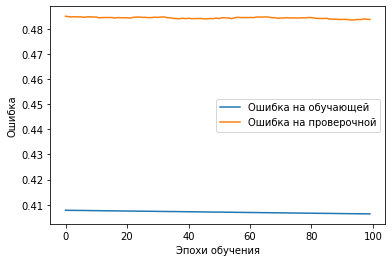

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train, Y_train,
                    epochs=100,
                    batch_size=12,
                    validation_data= (X_test, Y_test),
                    verbose=1)    

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()  

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(X_test, Y_test, verbose=1)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

1/1 [==============================] - 0s 97ms/step - loss: 0.4837 - accuracy: 0.8095
[0.4836948812007904, 0.8095238208770752]
Доля верных ответов на тестовых данных, в процентах: 80.9524%


In [ ]:
pred = model.predict(X_test)

mse = np.mean(np.power(Y_test - pred, 2), axis=1)

mse_IN = mse[Y_test == 0] 
mse_AC = mse[Y_test == 1] 

In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_IN),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_IN),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_IN) / len(mse_IN),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_AC),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_AC),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_AC) / len(mse_AC),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.1829
Максимальная ошибка неактивных молекул: 0.6455
Средняя ошибка неактивных молекул: 0.43968552

Минимальная ошибка активных молекул: 0.1814
Максимальная ошибка активных молекул: 0.4035
Средняя ошибка активных молекул: 0.21846315


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_IN > bias # если ошибка больше порога - то неактивная
  isActive = mse_AC < bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.3)

Распознано неактивных молекул: 20%
Распознано активных молекул: 6%
Средняя точность распознавания: 13%


#**1 нейрон на выходе**

**Обучение на неактивных (INactive)**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]
df_train_False.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])
print()

# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=4096): # сделал nBits=4096
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример части вектора smal_active: {smal_active[77][:100]}')
print(f'Размер массива smal_active: {smal_active.shape}')
print()

# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример части вектора smal_active: {smal_inactive[77][:100]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')



Количество молекул активных: 206
Длинна вектора одной молекулы: 4096
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_active: (206, 4096)

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 4096
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_inactive: (5351, 4096)


In [ ]:
# смотрю максимальные и минимальные значения
smal_inactive.max(), smal_inactive.min(), 

(1, 0)

In [ ]:
# X_Train это наш smal_inactive
x_tr = smal_inactive

# ДЛя Y_Train создаю вектор из нулей
y_tr = np.zeros(x_tr.shape[0],)
x_tr.shape, y_tr.shape

((5351, 4096), (5351,))

In [ ]:
# разбиваю на выборки
X_train, X_test, Y_train, Y_test = train_test_split(x_tr, y_tr, test_size=0.04, shuffle=True) #shuffle=True - перемешиваем

# размеры
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5136, 4096), (5136,), (215, 4096), (215,))

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(1, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 40,981
Trainable params: 40,981
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3397 - accuracy: 0.9807 - val_loss: 0.1392 - val_accuracy: 1.0000
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0896 - accuracy: 1.0000 - val_loss: 0.0550 - val_accuracy: 1.0000
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0421 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 1.0000
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000

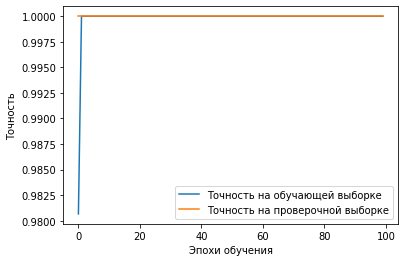

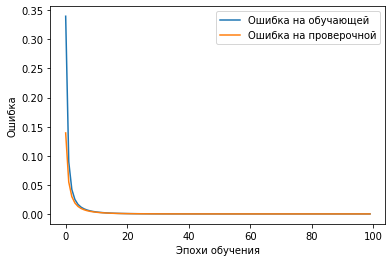

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train[:4500], Y_train[:4500],
                    epochs=100,
                    batch_size=12,
                    validation_data= (X_train[4500:], Y_train[4500:]), verbose=1
                    )

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Данные неактивных молекул, котоые сеть не видела

In [ ]:
# готовлю вектор для проверки на данных, которые сеть не видела

In [ ]:
predictions_IN = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions_IN.shape)
predictions_IN[1]


(215, 1)


array([8.1603916e-16], dtype=float32)

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
Inactiv_pred = sum(predictions_IN)/len(predictions_IN)
print(predictions_IN.shape)
print(Inactiv_pred)

(215, 1)
[1.5070235e-08]


Данные активных молекул, которые сеть не видела

In [ ]:
predictions_AC = model.predict(smal_active) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions_AC.shape)
predictions_AC[1]

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
Activ_pred = sum(predictions_AC)/len(predictions_AC)
print(predictions_IN.shape)
print(Activ_pred)

(215, 1)
[3.766762e-08]


In [ ]:
# По значениям предикта попробую отличать активные молекулы от неактивных

In [ ]:
x_test_IN_AC = np.concatenate((X_test, smal_active))
x_test_IN_AC.shape

(421, 4096)

In [ ]:
(3.766762 * 10 ** -8) > (1.5070235 * 10 ** -8)

True

In [ ]:
def getAccByBias(bias): 
  In_pred = predictions_IN > bias 
  Ac_pred = predictions_AC < bias 

  accInactive = sum(In_pred) / len(In_pred)
  accActive = sum(Ac_pred) / len(Ac_pred) 

  print("Распознано неактивных молекул: ", (100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", (100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", (50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias((3.766762 * 10 ** -8))

Распознано неактивных молекул: [98.60465116]%
Распознано активных молекул: [4.36893204]%
Средняя точность распознавания: [51.4867916]%


In [ ]:
predictions_test = model.predict(test) # делаем предсказание

In [ ]:
# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(predictions_test)):
  if i > (1.5070235 * 10 ** -8):
    submission['Active'].values[i] = True
  else:
    submission['Active'].values[i] = False

In [ ]:
submission.to_csv('submission.csv', index=False)

**Для активных**

In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=1024): # сделал nBits=1024
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример части вектора smal_active: {smal_active[77][:100]}')
print(f'Размер массива smal_active: {smal_active.shape}')
print()

# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример части вектора smal_active: {smal_inactive[77][:100]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 1024
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_active: (206, 1024)

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 1024
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_inactive: (5351, 1024)


In [ ]:
# смотрю максимальные и минимальные значения
smal_active.max(), smal_active.min(), 

(1, 0)

In [ ]:
# X_Tr это наш smal_active
x_tr = smal_active

# ДЛя Y_Train создаю вектор из нулей
y_tr = np.ones(x_tr.shape[0],)
x_tr.shape, y_tr.shape

((206, 1024), (206,))

In [ ]:
# разбиваю на выборки
X_train, X_test, Y_train, Y_test = train_test_split(x_tr, y_tr, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем

# размеры
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((185, 1024), (185,), (21, 1024), (21,))

In [ ]:
# рандомно выбираю 21 НЕактивную молекулы для будущего теста
smal_in = np.random.choice(5351, 21, replace = False)
smal_INactive = smal_inactive[smal_in]
y_inctive = np.zeros(21,)

print(smal_INactive.shape)

X_test = np.concatenate((X_test, smal_INactive))
print(X_test.shape)

Y_test = np.concatenate((Y_test, y_inctive))
print(Y_test.shape)

(21, 1024)
(42, 1024)
(42,)


In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 1024 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(1, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_8 (Dense)             (None, 10)                10250     
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10,261
Trainable params: 10,261
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
29/29 [==============================] - 1s 10ms/step - loss: 0.5345 - accuracy: 0.9588 - val_loss: 0.5312 - val_accuracy: 1.0000
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4751 - accuracy: 0.9941 - val_loss: 0.4768 - val_accuracy: 1.0000
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4191 - accuracy: 1.0000 - val_loss: 0.4235 - val_accuracy: 1.0000
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3650 - accuracy: 1.0000 - val_loss: 0.3741 - val_accuracy: 1.0000
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3157 - accuracy: 1.0000 - val_loss: 0.3300 - val_accuracy: 1.0000
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.2724 - accuracy: 1.0000 - val_loss: 0.2913 - val_accuracy: 1.0000
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.2346 - accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 1.0000
Epoch 8/100


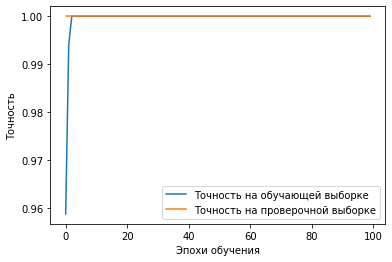

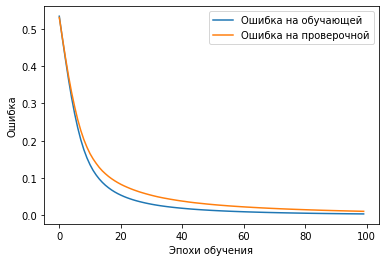

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train[:170], Y_train[:170],
                    epochs=100,
                    batch_size=6,
                    validation_data= (X_train[170:], Y_train[170:]), verbose=1
                    )

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


In [ ]:
predictions_AC = model.predict(X_test) 
print(predictions_AC.shape)
predictions_AC[1]

(42, 1)


array([0.9996915], dtype=float32)

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
Activ_pred = sum(predictions_AC)/len(predictions_AC)
print(predictions_AC.shape)
print(Activ_pred)

(42, 1)
[0.99313754]


In [ ]:
predictions_IN = model.predict(smal_INactive) 
print(predictions_IN.shape)
predictions_IN[1]


(21, 1)


array([0.9954562], dtype=float32)

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
INactiv_pred = sum(predictions_IN)/len(predictions_IN)
print(predictions_IN.shape)
print(INactiv_pred)

(21, 1)
[0.98834854]


#Составная нейронка с несколькими входами

In [3]:
import os
from dataclasses import dataclass
from enum import Enum
from functools import partial
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys

from typing import List

import numpy as np
from rdkit import Chem, DataStructs
from rdkit.DataStructs import ExplicitBitVect

In [4]:
def bit_vectors_to_numpy_arrays(fps: List[ExplicitBitVect]) -> np.array:
    output_arrays = [np.zeros((1,)) for i in range(len(fps))]
    _ = list(
        map(lambda fp_output_array: DataStructs.ConvertToNumpyArray(fp_output_array[0], fp_output_array[1]),
            zip(fps, output_arrays)))
    return np.asarray(output_arrays)


def get_np_array_of_fps(fp_type, smiles: List[str]):
    # Calculate the morgan fingerprint
    mols = [Chem.MolFromSmiles(m) for m in smiles]
    fp = list(map(fp_type, mols))
    return bit_vectors_to_numpy_arrays(fp)

In [5]:
class FingerprintsNames(Enum):
    TOPOTORSION = "topological_torsion"
    MACCS = "MACCSkeys"
    RDKitFP = "RDKFingerprint"
    PATTERN = "PatternFingerprint"
    ATOMPAIR = "AtomPairFingerprint"
    ECFP4 = "morgan_2_2048"


FINGERPRINTS_METHODS = {FingerprintsNames.TOPOTORSION: AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect,
                        FingerprintsNames.MACCS: MACCSkeys.GenMACCSKeys,
                        FingerprintsNames.RDKitFP: Chem.RDKFingerprint,
                        FingerprintsNames.PATTERN: Chem.PatternFingerprint,
                        FingerprintsNames.ATOMPAIR: AllChem.GetHashedAtomPairFingerprintAsBitVect,
                        FingerprintsNames.ECFP4: partial(AllChem.GetMorganFingerprintAsBitVect, radius=2, nBits=2048)
                        }

In [ ]:
type(s_active)

list

**Подготовка данных**

In [169]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_test = pd.read_csv('/content/test.csv', index_col = 0)

# собираю значения Smiles НЕактивных молекул в лист
s_inactive = []
for i in df_train_new[df_train_new.Active==False]['Smiles']:
  s_inactive.append(i)
print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])
print()

# # собираю значения Smiles Активных молекул в лист
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)
print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])
print()

# test
TEST = []
for i in df_test['Smiles']:
  TEST.append(i)

print('Длинна test:', len(TEST))
print("Пример значения из test:", TEST[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23

Длинна test: 1614
Пример значения из test: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12


In [173]:
type(s_active)

numpy.ndarray

In [174]:
s_inactive = np.array(s_inactive)
s_active =  np.array(s_active)
print(s_inactive.shape)
print(s_active.shape)

(5351,)
(206,)


In [175]:
# общий Y_Train для всех входов
i = np.random.choice(5351, 206, replace = False)
smal_inactive = s_inactive[i]

Y_inactive = np.zeros(206,)
print(Y_inactive.shape)
print(Y_inactive[9])
print()

Y_active = np.ones(206,)
print(Y_active.shape)
print(Y_active[9])

(206,)
0.0

(206,)
1.0


In [176]:
X_tr = np.concatenate((smal_inactive, s_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape
# преобразую в hot
Y_Train = utils.to_categorical(Y_tr, 2)
print(Y_tr.shape)
print(Y_Train[5])    #для неактивной
print(Y_Train[300])  #для активной

(412,)
[1. 0.]
[0. 1.]


In [ ]:
#i = np.random.choice(5351, 16, replace = False )


**Готовлю тестовую выборку для проверки после обучения**

In [177]:
#X_test_1 - 21 молекула
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_tr, Y_Train, test_size=0.05, shuffle=True) #shuffle=True - перемешиваем
X_train_1.shape, X_test_1.shape, Y_train_1.shape, Y_test_1.shape

((391,), (21,), (391, 2), (21, 2))

**Готовлю общие X_train и X_test для всех входов**

In [178]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_1, Y_train_1, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((351,), (40,), (351, 2), (40, 2))

In [179]:
type(X_train), type(Y_test)

(numpy.ndarray, numpy.ndarray)

In [180]:
X_train[9]

'CCOc1ccc(Nc2nc(-c3c(C)nc4ccccn34)cs2)cc1'

**TOPOTORSION**

In [181]:
X_train_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], list(X_train))
X_test_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], list(X_test))
test_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], list(X_test_1))
TEST_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], TEST)
print(X_train_T.shape)
print(X_test_T.shape)
print(test_T.shape)
print(TEST_T.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**MACCS**

In [185]:
X_train_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], list(X_train))
X_test_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], list(X_test))
test_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], list(X_test_1))
TEST_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], TEST)
print(X_train_M.shape)
print(X_test_M.shape)
print(test_M.shape)
print(TEST_M.shape)

(351, 167)
(40, 167)
(21, 167)
(1614, 167)


**RDKitFP**

In [186]:
X_train_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], list(X_train))
X_test_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], list(X_test))
test_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], list(X_test_1))
TEST_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], TEST)
print(X_train_R.shape)
print(X_test_R.shape)
print(test_R.shape)
print(TEST_R.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**PATTERN**

In [187]:
X_train_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], list(X_train))
X_test_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], list(X_test))
test_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], list(X_test_1))
TEST_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], TEST)
print(X_train_P.shape)
print(X_test_P.shape)
print(test_P.shape)
print(TEST_P.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**ATOMPAIR**

In [189]:
X_train_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], list(X_train))
X_test_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], list(X_test))
test_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], list(X_test_1))
TEST_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], TEST)
print(X_train_A.shape)
print(X_test_A.shape)
print(test_A.shape)
print(TEST_A.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**ECFP4**

In [190]:
X_train_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], list(X_train))
X_test_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], list(X_test))
test_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], list(X_test_1))
TEST_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], TEST)
print(X_train_E.shape)
print(X_test_E.shape)
print(test_E.shape)
print(TEST_E.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**Нейросеть**

In [191]:
def model_6x():

  input1 = Input((X_train_T.shape[1],))
  input2 = Input((X_train_M.shape[1],))
  input3 = Input((X_train_R.shape[1],))
  input4 = Input((X_train_P.shape[1],))
  input5 = Input((X_train_A.shape[1],))
  input6 = Input((X_train_E.shape[1],))

  x1 = Dense(99, activation='relu')(input1) 
  x1 = BatchNormalization()(x1)
  x1 = Dropout(0.7) (x1)
  x1 = Dense(13, activation='relu') (x1)
  x1 = BatchNormalization()(x1)
  x1 = Dropout(0.1) (x1)
  x1 = Dense(7, activation='relu') (x1)

  x2 = Dense(99, activation='relu')(input2) 
  x2 = BatchNormalization()(x2)
  x2 = Dropout(0.7) (x2)
  x2 = Dense(13, activation='relu') (x2)
  x2 = BatchNormalization()(x2)
  x2 = Dropout(0.1) (x2)
  x2 = Dense(7, activation='relu') (x2)

  x3 = Dense(99, activation='relu')(input3) 
  x3 = BatchNormalization()(x3)
  x3 = Dropout(0.7) (x3)
  x3 = Dense(13, activation='relu') (x3)
  x3 = BatchNormalization()(x3)
  x3 = Dropout(0.1) (x3)
  x3 = Dense(7, activation='relu') (x3)

  x4 = Dense(99, activation='relu')(input4) 
  x4 = BatchNormalization()(x4)
  x4 = Dropout(0.7) (x4)
  x4 = Dense(13, activation='relu') (x4)
  x4 = BatchNormalization()(x4)
  x4 = Dropout(0.1) (x4)
  x4 = Dense(7, activation='relu') (x4)

  x5 = Dense(99, activation='relu')(input5) 
  x5 = BatchNormalization()(x5)
  x5 = Dropout(0.7) (x5)
  x5 = Dense(13, activation='relu') (x5)
  x5 = BatchNormalization()(x5)
  x5 = Dropout(0.1) (x5)
  x5 = Dense(7, activation='relu') (x5)

  x6 = Dense(99, activation='relu')(input6) 
  x6 = BatchNormalization()(x6)
  x6 = Dropout(0.7) (x6)
  x6 = Dense(13, activation='relu') (x6)
  x6 = BatchNormalization()(x6)
  x6 = Dropout(0.1) (x6)
  x6 = Dense(7, activation='relu') (x6)


  x = concatenate([x1, x2, x3, x4, x5, x6]) # Объединяем все 6 веток

  x = Dense(31, activation='relu')(x)
  #x = Dropout(0.2)(x)
  x = Dense(2, activation='softmax')(x) # Финальные 2 нейрона
  model = Model((input1, input2, input3, input4, input5, input6), x)

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
  
  return model

In [192]:
model = model_6x()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 167)]        0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_76 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                           

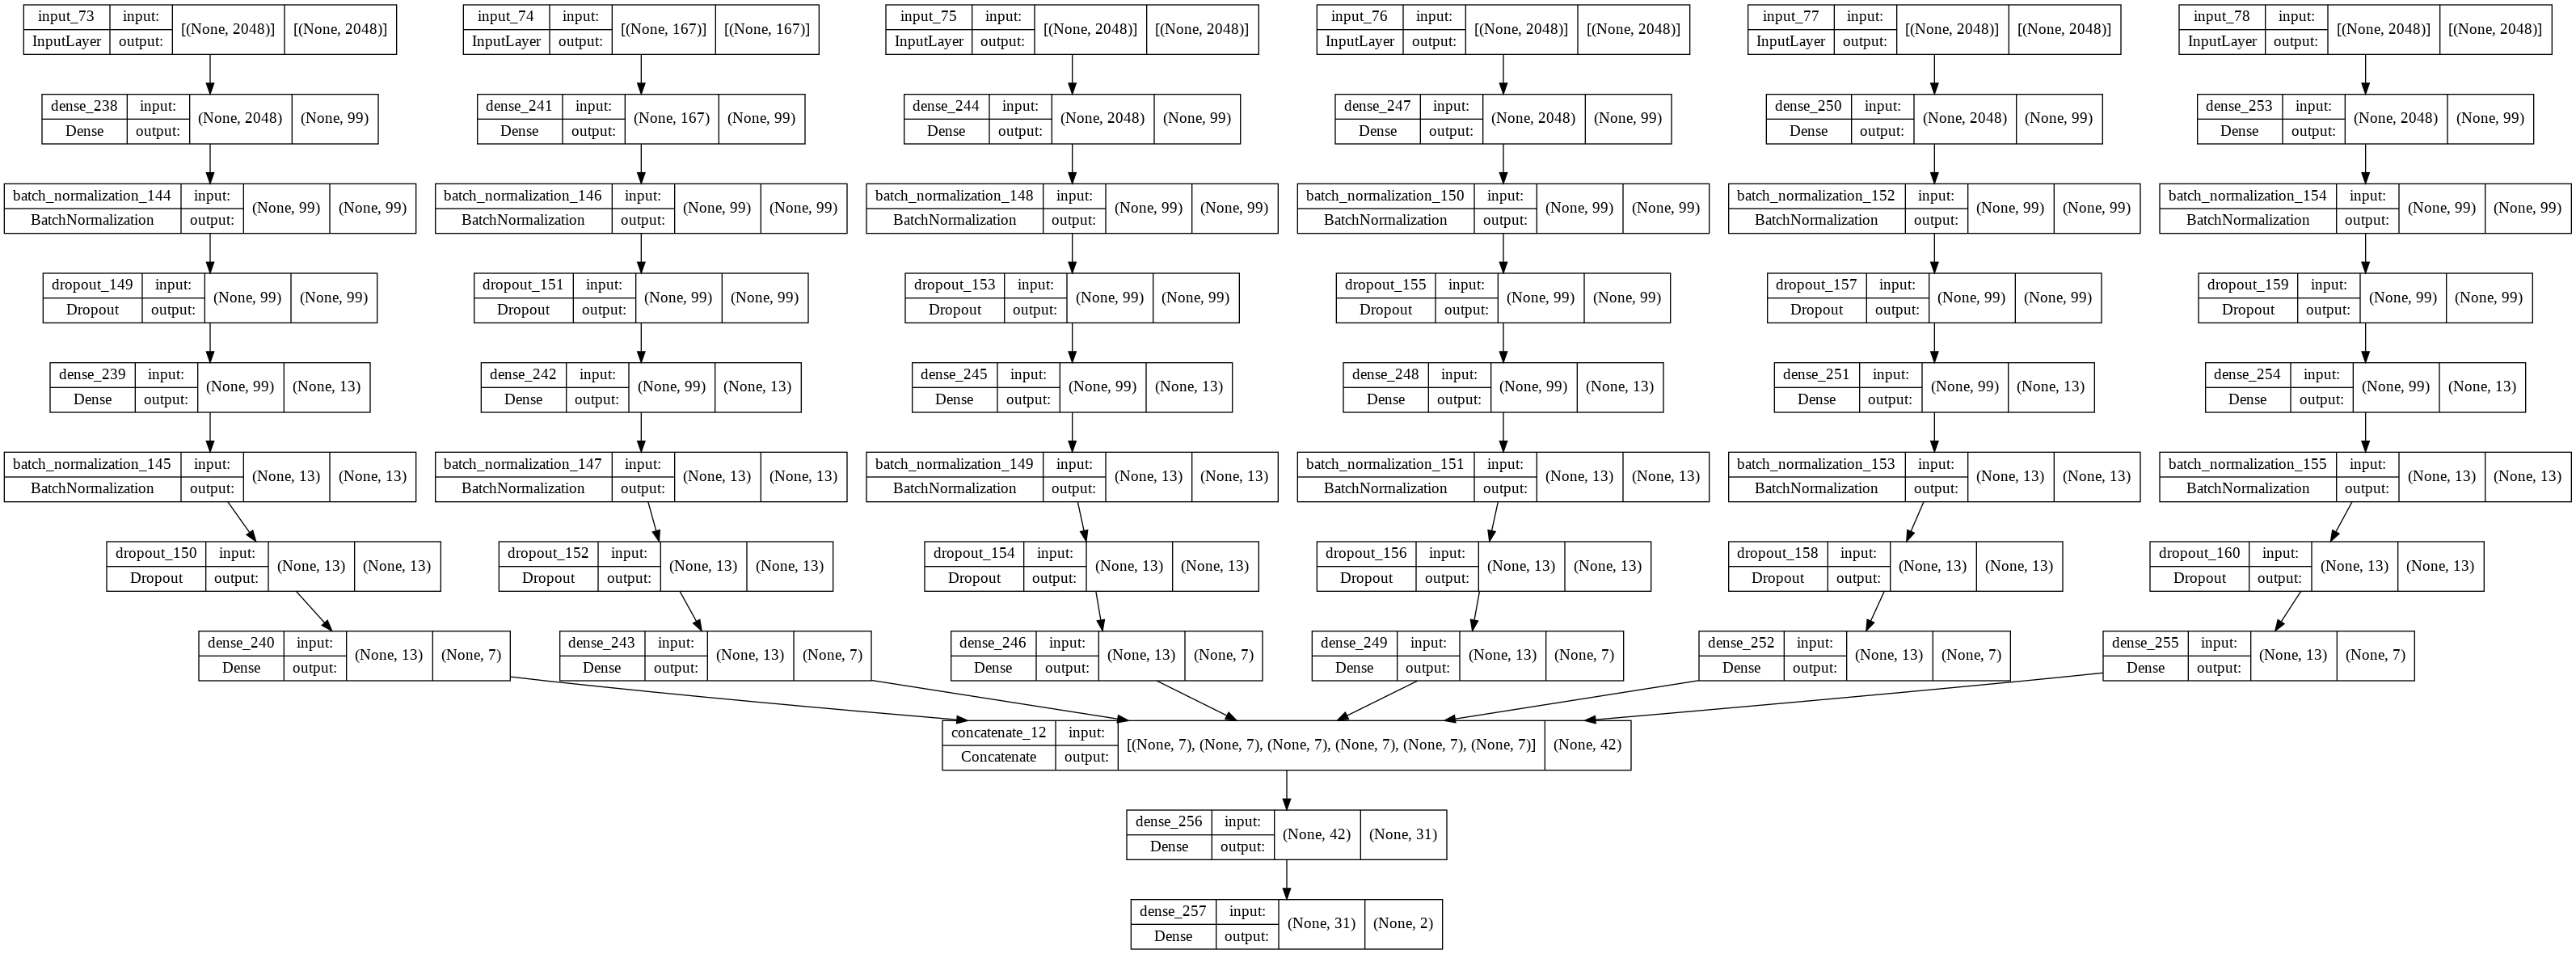

In [193]:
plot_model(model,show_shapes=True)

Epoch 1/150
22/22 [==============================] - 5s 48ms/step - loss: 0.8378 - accuracy: 0.5071 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/150
22/22 [==============================] - 0s 20ms/step - loss: 0.8739 - accuracy: 0.4672 - val_loss: 0.6760 - val_accuracy: 0.5750
Epoch 3/150
22/22 [==============================] - 0s 21ms/step - loss: 0.8213 - accuracy: 0.4929 - val_loss: 0.6713 - val_accuracy: 0.6250
Epoch 4/150
22/22 [==============================] - 0s 21ms/step - loss: 0.8139 - accuracy: 0.5071 - val_loss: 0.6685 - val_accuracy: 0.6000
Epoch 5/150
22/22 [==============================] - 0s 21ms/step - loss: 0.7815 - accuracy: 0.5271 - val_loss: 0.6689 - val_accuracy: 0.5750
Epoch 6/150
22/22 [==============================] - 0s 20ms/step - loss: 0.8055 - accuracy: 0.4957 - val_loss: 0.6690 - val_accuracy: 0.5750
Epoch 7/150
22/22 [==============================] - 0s 21ms/step - loss: 0.8151 - accuracy: 0.5128 - val_loss: 0.6695 - val_accuracy: 0.5750
Epoch 

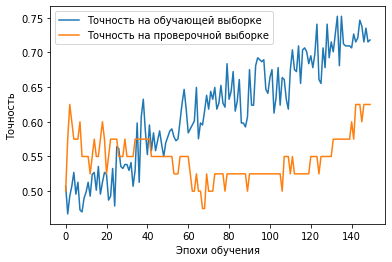

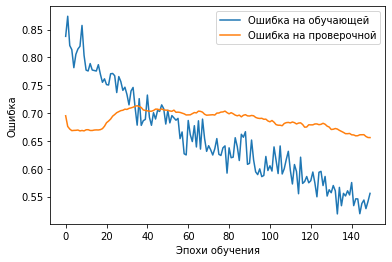

In [194]:
#model = model_6x()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

history = model.fit([X_train_T, X_train_M, X_train_R, X_train_P, X_train_A, X_train_E], 
                    Y_train, 
                    epochs= 150,
                    batch_size=16,  
                    validation_data=([X_test_T, X_test_M, X_test_R, X_test_P, X_test_A, X_test_E], 
                    Y_test), 
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/150
22/22 [==============================] - 1s 23ms/step - loss: 0.5555 - accuracy: 0.7009 - val_loss: 0.6568 - val_accuracy: 0.6250
Epoch 2/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5546 - accuracy: 0.7236 - val_loss: 0.6611 - val_accuracy: 0.6500
Epoch 3/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5260 - accuracy: 0.7721 - val_loss: 0.6598 - val_accuracy: 0.6500
Epoch 4/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5417 - accuracy: 0.7436 - val_loss: 0.6577 - val_accuracy: 0.6500
Epoch 5/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5420 - accuracy: 0.7379 - val_loss: 0.6573 - val_accuracy: 0.6500
Epoch 6/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5258 - accuracy: 0.7350 - val_loss: 0.6532 - val_accuracy: 0.6500
Epoch 7/150
22/22 [==============================] - 0s 22ms/step - loss: 0.5154 - accuracy: 0.7692 - val_loss: 0.6497 - val_accuracy: 0.6500
Epoch 

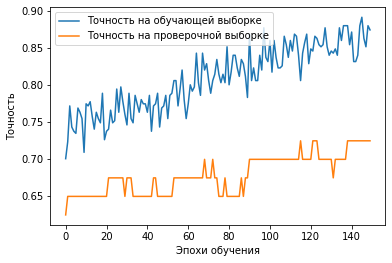

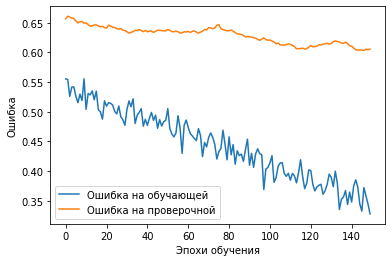

In [195]:
history = model.fit([X_train_T, X_train_M, X_train_R, X_train_P, X_train_A, X_train_E], 
                    Y_train, 
                    epochs= 150,
                    batch_size=16,  
                    validation_data=([X_test_T, X_test_M, X_test_R, X_test_P, X_test_A, X_test_E], 
                    Y_test), 
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/150
22/22 [==============================] - 10s 51ms/step - loss: 0.3129 - accuracy: 0.8832 - val_loss: 0.6057 - val_accuracy: 0.7250
Epoch 2/150
22/22 [==============================] - 1s 23ms/step - loss: 0.3282 - accuracy: 0.9031 - val_loss: 0.6056 - val_accuracy: 0.7250
Epoch 3/150
22/22 [==============================] - 1s 23ms/step - loss: 0.3203 - accuracy: 0.9060 - val_loss: 0.6073 - val_accuracy: 0.7250
Epoch 4/150
22/22 [==============================] - 1s 25ms/step - loss: 0.3236 - accuracy: 0.8832 - val_loss: 0.6077 - val_accuracy: 0.7000
Epoch 5/150
22/22 [==============================] - 1s 24ms/step - loss: 0.3393 - accuracy: 0.9031 - val_loss: 0.6077 - val_accuracy: 0.7000
Epoch 6/150
22/22 [==============================] - 1s 24ms/step - loss: 0.3614 - accuracy: 0.8462 - val_loss: 0.6081 - val_accuracy: 0.7000
Epoch 7/150
22/22 [==============================] - 0s 22ms/step - loss: 0.3547 - accuracy: 0.8519 - val_loss: 0.6081 - val_accuracy: 0.7000
Epoch

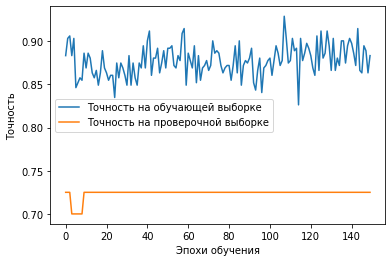

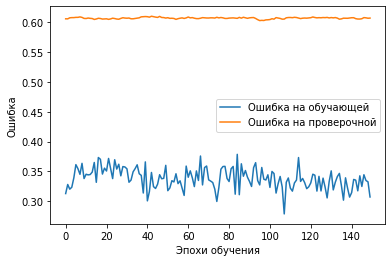

In [196]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

history = model.fit([X_train_T, X_train_M, X_train_R, X_train_P, X_train_A, X_train_E], 
                    Y_train, 
                    epochs= 150,
                    batch_size=16,  
                    validation_data=([X_test_T, X_test_M, X_test_R, X_test_P, X_test_A, X_test_E], 
                    Y_test), 
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [205]:
n = 2
predictions = model.predict([test_T, test_M, test_R, test_P, test_A, test_E])

print("Выход сети: ", predictions[n])
print("Распознанная молекула: ", np.argmax(predictions[n]))
print("Верный ответ: ", np.argmax(Y_test_1[n]))

Выход сети:  [0.5265518 0.4734482]
Распознанная молекула:  0
Верный ответ:  0


In [200]:
b = 0
for i in range(len(predictions)):
  p = np.argmax(prediction[i])
  y = np.argmax(Y_test[i])
  if y == p:
    b += 1
print("Средняя точность распознавания: ", round(b / len(predictions),4), "%", sep="") 

Средняя точность распознавания: 0.381%


In [201]:
predictions_TEST = model.predict([TEST_T, TEST_M, TEST_R, TEST_P, TEST_A, TEST_E])

# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(predictions_TEST)):
  submission['Active'].values[i] = np.argmax(predictions_TEST[i])

submission.to_csv('submission.csv', index=False)

In [202]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,1
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,0
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [206]:
import os
from dataclasses import dataclass
from enum import Enum
from functools import partial
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys

from typing import List

import numpy as np
from rdkit import Chem, DataStructs
from rdkit.DataStructs import ExplicitBitVect

In [207]:
def bit_vectors_to_numpy_arrays(fps: List[ExplicitBitVect]) -> np.array:
    output_arrays = [np.zeros((1,)) for i in range(len(fps))]
    _ = list(
        map(lambda fp_output_array: DataStructs.ConvertToNumpyArray(fp_output_array[0], fp_output_array[1]),
            zip(fps, output_arrays)))
    return np.asarray(output_arrays)


def get_np_array_of_fps(fp_type, smiles: List[str]):
    # Calculate the morgan fingerprint
    mols = [Chem.MolFromSmiles(m) for m in smiles]
    fp = list(map(fp_type, mols))
    return bit_vectors_to_numpy_arrays(fp)

In [208]:
class FingerprintsNames(Enum):
    TOPOTORSION = "topological_torsion"
    MACCS = "MACCSkeys"
    RDKitFP = "RDKFingerprint"
    PATTERN = "PatternFingerprint"
    ATOMPAIR = "AtomPairFingerprint"
    ECFP4 = "morgan_2_2048"


FINGERPRINTS_METHODS = {FingerprintsNames.TOPOTORSION: AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect,
                        FingerprintsNames.MACCS: MACCSkeys.GenMACCSKeys,
                        FingerprintsNames.RDKitFP: Chem.RDKFingerprint,
                        FingerprintsNames.PATTERN: Chem.PatternFingerprint,
                        FingerprintsNames.ATOMPAIR: AllChem.GetHashedAtomPairFingerprintAsBitVect,
                        FingerprintsNames.ECFP4: partial(AllChem.GetMorganFingerprintAsBitVect, radius=2, nBits=2048)
                        }

In [209]:
type(s_active)

numpy.ndarray

**Подготовка данных**

In [210]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_test = pd.read_csv('/content/test.csv', index_col = 0)

# собираю значения Smiles НЕактивных молекул в лист
s_inactive = []
for i in df_train_new[df_train_new.Active==False]['Smiles']:
  s_inactive.append(i)
print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])
print()

# # собираю значения Smiles Активных молекул в лист
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)
print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])
print()

# test
TEST = []
for i in df_test['Smiles']:
  TEST.append(i)

print('Длинна test:', len(TEST))
print("Пример значения из test:", TEST[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23

Длинна test: 1614
Пример значения из test: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12


In [ ]:
type(s_active)

numpy.ndarray

In [211]:
s_inactive = np.array(s_inactive)
s_active =  np.array(s_active)
print(s_inactive.shape)
print(s_active.shape)

(5351,)
(206,)


In [ ]:
# общий Y_Train для всех входов
i = np.random.choice(5351, 206, replace = False)
smal_inactive = s_inactive[i]

Y_inactive = np.zeros(206,)
print(Y_inactive.shape)
print(Y_inactive[9])
print()

Y_active = np.ones(206,)
print(Y_active.shape)
print(Y_active[9])

(206,)
0.0

(206,)
1.0


In [ ]:
X_tr = np.concatenate((smal_inactive, s_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape
# преобразую в hot
Y_Train = utils.to_categorical(Y_tr, 2)
print(Y_tr.shape)
print(Y_Train[5])    #для неактивной
print(Y_Train[300])  #для активной

(412,)
[1. 0.]
[0. 1.]


In [ ]:
#i = np.random.choice(5351, 16, replace = False )


**Готовлю тестовую выборку для проверки после обучения**

In [ ]:
#X_test_1 - 21 молекула
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_tr, Y_Train, test_size=0.05, shuffle=True) #shuffle=True - перемешиваем
X_train_1.shape, X_test_1.shape, Y_train_1.shape, Y_test_1.shape

((391,), (21,), (391, 2), (21, 2))

**Готовлю общие X_train и X_test для всех входов**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_1, Y_train_1, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((351,), (40,), (351, 2), (40, 2))

In [ ]:
type(X_train), type(Y_test)

(numpy.ndarray, numpy.ndarray)

In [ ]:
X_train[9]

'CCOc1ccc(Nc2nc(-c3c(C)nc4ccccn34)cs2)cc1'

**TOPOTORSION**

In [ ]:
X_train_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], list(X_train))
X_test_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], list(X_test))
test_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], list(X_test_1))
TEST_T = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.TOPOTORSION], TEST)
print(X_train_T.shape)
print(X_test_T.shape)
print(test_T.shape)
print(TEST_T.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**MACCS**

In [ ]:
X_train_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], list(X_train))
X_test_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], list(X_test))
test_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], list(X_test_1))
TEST_M = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.MACCS], TEST)
print(X_train_M.shape)
print(X_test_M.shape)
print(test_M.shape)
print(TEST_M.shape)

(351, 167)
(40, 167)
(21, 167)
(1614, 167)


**RDKitFP**

In [ ]:
X_train_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], list(X_train))
X_test_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], list(X_test))
test_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], list(X_test_1))
TEST_R = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.RDKitFP], TEST)
print(X_train_R.shape)
print(X_test_R.shape)
print(test_R.shape)
print(TEST_R.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**PATTERN**

In [ ]:
X_train_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], list(X_train))
X_test_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], list(X_test))
test_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], list(X_test_1))
TEST_P = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.PATTERN], TEST)
print(X_train_P.shape)
print(X_test_P.shape)
print(test_P.shape)
print(TEST_P.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**ATOMPAIR**

In [ ]:
X_train_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], list(X_train))
X_test_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], list(X_test))
test_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], list(X_test_1))
TEST_A = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ATOMPAIR], TEST)
print(X_train_A.shape)
print(X_test_A.shape)
print(test_A.shape)
print(TEST_A.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**ECFP4**

In [ ]:
X_train_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], list(X_train))
X_test_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], list(X_test))
test_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], list(X_test_1))
TEST_E = get_np_array_of_fps(FINGERPRINTS_METHODS[FingerprintsNames.ECFP4], TEST)
print(X_train_E.shape)
print(X_test_E.shape)
print(test_E.shape)
print(TEST_E.shape)

(351, 2048)
(40, 2048)
(21, 2048)
(1614, 2048)


**Нейросеть**

In [ ]:
def model_6x():

  input1 = Input((X_train_T.shape[1],))
  input2 = Input((X_train_M.shape[1],))
  input3 = Input((X_train_R.shape[1],))
  input4 = Input((X_train_P.shape[1],))
  input5 = Input((X_train_A.shape[1],))
  input6 = Input((X_train_E.shape[1],))

  x1 = Dense(99, activation='relu')(input1) 
  x1 = BatchNormalization()(x1)
  x1 = Dropout(0.7) (x1)
  x1 = Dense(13, activation='relu') (x1)
  x1 = BatchNormalization()(x1)
  x1 = Dropout(0.1) (x1)
  x1 = Dense(7, activation='relu') (x1)

  x2 = Dense(99, activation='relu')(input2) 
  x2 = BatchNormalization()(x2)
  x2 = Dropout(0.7) (x2)
  x2 = Dense(13, activation='relu') (x2)
  x2 = BatchNormalization()(x2)
  x2 = Dropout(0.1) (x2)
  x2 = Dense(7, activation='relu') (x2)

  x3 = Dense(99, activation='relu')(input3) 
  x3 = BatchNormalization()(x3)
  x3 = Dropout(0.7) (x3)
  x3 = Dense(13, activation='relu') (x3)
  x3 = BatchNormalization()(x3)
  x3 = Dropout(0.1) (x3)
  x3 = Dense(7, activation='relu') (x3)

  x4 = Dense(99, activation='relu')(input4) 
  x4 = BatchNormalization()(x4)
  x4 = Dropout(0.7) (x4)
  x4 = Dense(13, activation='relu') (x4)
  x4 = BatchNormalization()(x4)
  x4 = Dropout(0.1) (x4)
  x4 = Dense(7, activation='relu') (x4)

  x5 = Dense(99, activation='relu')(input5) 
  x5 = BatchNormalization()(x5)
  x5 = Dropout(0.7) (x5)
  x5 = Dense(13, activation='relu') (x5)
  x5 = BatchNormalization()(x5)
  x5 = Dropout(0.1) (x5)
  x5 = Dense(7, activation='relu') (x5)

  x6 = Dense(99, activation='relu')(input6) 
  x6 = BatchNormalization()(x6)
  x6 = Dropout(0.7) (x6)
  x6 = Dense(13, activation='relu') (x6)
  x6 = BatchNormalization()(x6)
  x6 = Dropout(0.1) (x6)
  x6 = Dense(7, activation='relu') (x6)


  x = concatenate([x1, x2, x3, x4, x5, x6]) # Объединяем все 6 веток

  x = Dense(31, activation='relu')(x)
  #x = Dropout(0.2)(x)
  x = Dense(2, activation='softmax')(x) # Финальные 2 нейрона
  model = Model((input1, input2, input3, input4, input5, input6), x)

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
  
  return model

In [ ]:
model = model_6x()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 167)]        0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_76 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                           

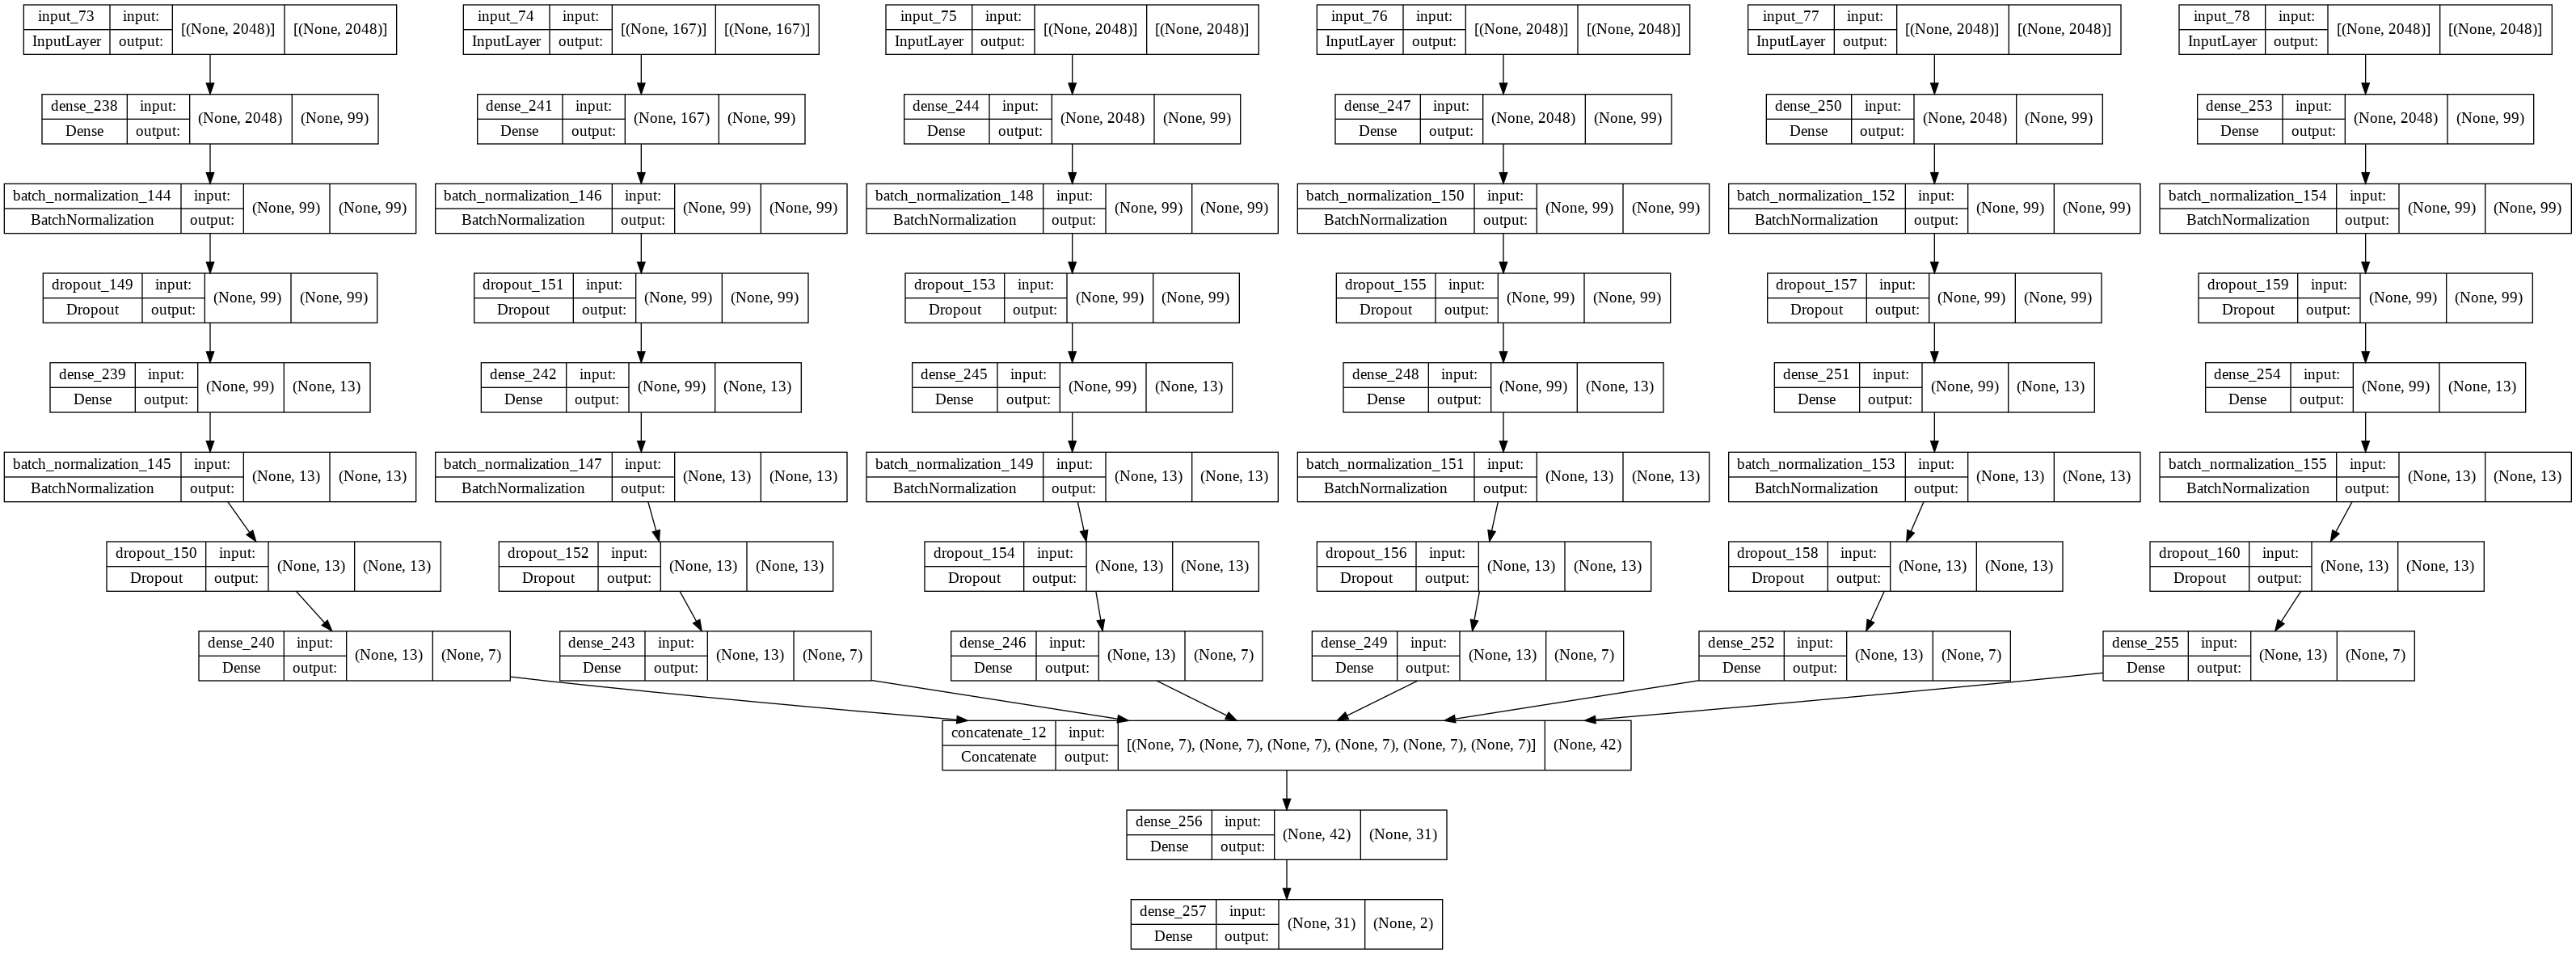

In [ ]:
plot_model(model,show_shapes=True)

Epoch 1/150
22/22 [==============================] - 5s 48ms/step - loss: 0.8378 - accuracy: 0.5071 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/150
22/22 [==============================] - 0s 20ms/step - loss: 0.8739 - accuracy: 0.4672 - val_loss: 0.6760 - val_accuracy: 0.5750
Epoch 3/150
22/22 [==============================] - 0s 21ms/step - loss: 0.8213 - accuracy: 0.4929 - val_loss: 0.6713 - val_accuracy: 0.6250
Epoch 4/150
22/22 [==============================] - 0s 21ms/step - loss: 0.8139 - accuracy: 0.5071 - val_loss: 0.6685 - val_accuracy: 0.6000
Epoch 5/150
22/22 [==============================] - 0s 21ms/step - loss: 0.7815 - accuracy: 0.5271 - val_loss: 0.6689 - val_accuracy: 0.5750
Epoch 6/150
22/22 [==============================] - 0s 20ms/step - loss: 0.8055 - accuracy: 0.4957 - val_loss: 0.6690 - val_accuracy: 0.5750
Epoch 7/150
22/22 [==============================] - 0s 21ms/step - loss: 0.8151 - accuracy: 0.5128 - val_loss: 0.6695 - val_accuracy: 0.5750
Epoch 

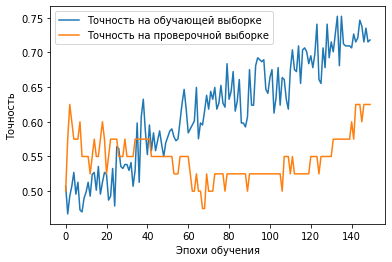

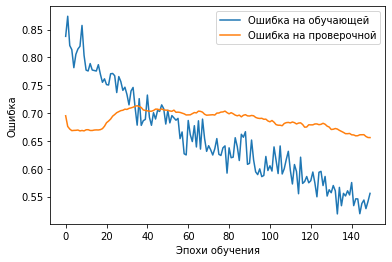

In [ ]:
#model = model_6x()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

history = model.fit([X_train_T, X_train_M, X_train_R, X_train_P, X_train_A, X_train_E], 
                    Y_train, 
                    epochs= 150,
                    batch_size=16,  
                    validation_data=([X_test_T, X_test_M, X_test_R, X_test_P, X_test_A, X_test_E], 
                    Y_test), 
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/150
22/22 [==============================] - 1s 23ms/step - loss: 0.5555 - accuracy: 0.7009 - val_loss: 0.6568 - val_accuracy: 0.6250
Epoch 2/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5546 - accuracy: 0.7236 - val_loss: 0.6611 - val_accuracy: 0.6500
Epoch 3/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5260 - accuracy: 0.7721 - val_loss: 0.6598 - val_accuracy: 0.6500
Epoch 4/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5417 - accuracy: 0.7436 - val_loss: 0.6577 - val_accuracy: 0.6500
Epoch 5/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5420 - accuracy: 0.7379 - val_loss: 0.6573 - val_accuracy: 0.6500
Epoch 6/150
22/22 [==============================] - 0s 21ms/step - loss: 0.5258 - accuracy: 0.7350 - val_loss: 0.6532 - val_accuracy: 0.6500
Epoch 7/150
22/22 [==============================] - 0s 22ms/step - loss: 0.5154 - accuracy: 0.7692 - val_loss: 0.6497 - val_accuracy: 0.6500
Epoch 

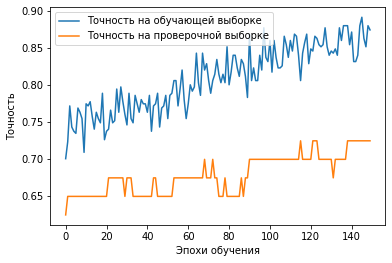

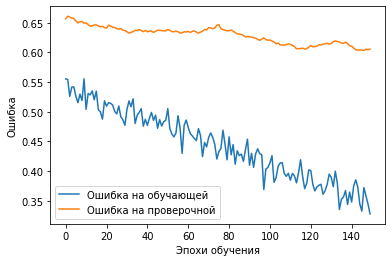

In [ ]:
history = model.fit([X_train_T, X_train_M, X_train_R, X_train_P, X_train_A, X_train_E], 
                    Y_train, 
                    epochs= 150,
                    batch_size=16,  
                    validation_data=([X_test_T, X_test_M, X_test_R, X_test_P, X_test_A, X_test_E], 
                    Y_test), 
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/150
22/22 [==============================] - 10s 51ms/step - loss: 0.3129 - accuracy: 0.8832 - val_loss: 0.6057 - val_accuracy: 0.7250
Epoch 2/150
22/22 [==============================] - 1s 23ms/step - loss: 0.3282 - accuracy: 0.9031 - val_loss: 0.6056 - val_accuracy: 0.7250
Epoch 3/150
22/22 [==============================] - 1s 23ms/step - loss: 0.3203 - accuracy: 0.9060 - val_loss: 0.6073 - val_accuracy: 0.7250
Epoch 4/150
22/22 [==============================] - 1s 25ms/step - loss: 0.3236 - accuracy: 0.8832 - val_loss: 0.6077 - val_accuracy: 0.7000
Epoch 5/150
22/22 [==============================] - 1s 24ms/step - loss: 0.3393 - accuracy: 0.9031 - val_loss: 0.6077 - val_accuracy: 0.7000
Epoch 6/150
22/22 [==============================] - 1s 24ms/step - loss: 0.3614 - accuracy: 0.8462 - val_loss: 0.6081 - val_accuracy: 0.7000
Epoch 7/150
22/22 [==============================] - 0s 22ms/step - loss: 0.3547 - accuracy: 0.8519 - val_loss: 0.6081 - val_accuracy: 0.7000
Epoch

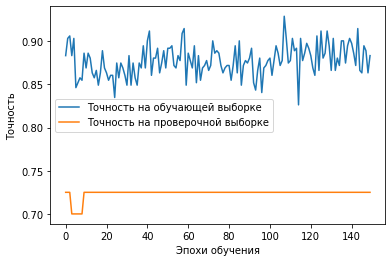

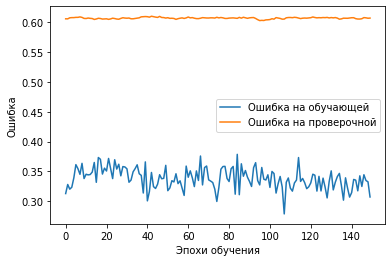

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

history = model.fit([X_train_T, X_train_M, X_train_R, X_train_P, X_train_A, X_train_E], 
                    Y_train, 
                    epochs= 150,
                    batch_size=16,  
                    validation_data=([X_test_T, X_test_M, X_test_R, X_test_P, X_test_A, X_test_E], 
                    Y_test), 
                    verbose=1, shuffle=True)

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
n = 19
predictions = model.predict([test_T, test_M, test_R, test_P, test_A, test_E])

print("Выход сети: ", predictions[n])
print("Распознанная молекула: ", np.argmax(predictions[n]))
print("Верный ответ: ", np.argmax(Y_test_1[n]))

Выход сети:  [0.7276708  0.27232924]
Распознанная молекула:  0
Верный ответ:  0


In [ ]:
b = 0
for i in range(len(predictions)):
  p = np.argmax(prediction[i])
  y = np.argmax(Y_test[i])
  if y == p:
    b += 1
print("Средняя точность распознавания: ", round(b / len(predictions),4), "%", sep="") 

Средняя точность распознавания: 0.381%


In [ ]:
predictions_TEST = model.predict([TEST_T, TEST_M, TEST_R, TEST_P, TEST_A, TEST_E])

# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(predictions_TEST)):
  submission['Active'].values[i] = np.argmax(predictions_TEST[i])

submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,1
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,0
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


#Подбор гиперпараметров сети генетическим алгоритмом